In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
#from qiskit.tools.jupyter import *
#from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

from qiskit import QuantumCircuit, execute, Aer
from qiskit.circuit import QuantumRegister, Qubit, Gate, ClassicalRegister
from qiskit.aqua.components.oracles import Oracle, TruthTableOracle
from qiskit.quantum_info import Statevector

# Transpiling stuff
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler.passes import BasicSwap, LookaheadSwap, StochasticSwap
from qiskit.transpiler import CouplingMap, Layout


#import utils
from collections import OrderedDict

import math
import numpy as np
from sympy.combinatorics.graycode import GrayCode, bin_to_gray, gray_to_bin

# Import general libraries (needed for functions)
import time

# Import Qiskit classes
import qiskit
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

from qiskit.test.mock import FakeYorktown

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
!pip install mitiq
import mitiq

  Using cached mitiq-0.2.0-py3-none-any.whl (61 kB)
  Using cached cirq_unstable-0.9.0.dev20200813185757-py3-none-any.whl (1.5 MB)
  Using cached numpy-1.18.5-cp37-cp37m-manylinux1_x86_64.whl (20.1 MB)
  Using cached protobuf-3.12.4-cp37-cp37m-manylinux1_x86_64.whl (1.3 MB)
  Using cached google_api_core-1.23.0-py2.py3-none-any.whl (91 kB)
  Using cached freezegun-0.3.15-py2.py3-none-any.whl (14 kB)
  Using cached googleapis_common_protos-1.52.0-py2.py3-none-any.whl (100 kB)
  Using cached google_auth-1.22.1-py2.py3-none-any.whl (114 kB)
     |████████████████████████████████| 3.8 MB 10.5 MB/s eta 0:00:01
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached cachetools-4.1.1-py3-none-any.whl (10 kB)
  Using cached rsa-4.6-py3-none-any.whl (47 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.11.4
    Uninstalling protobuf-3.11.4:
      Successfully uninstalled protobuf-3.1

In [3]:
number_W = 2
beta = 1

provider = IBMQ.get_provider(hub='ibm-q-research', group='Pablo-Antonio-Mo', project='main') 
print(provider)
backends = provider.backends()
for backend in backends:
    print(backend.name())
    
backend = provider.backends(name = 'ibmq_casablanca')[0]
properties = backend.properties() 
coupling_map = backend.configuration().coupling_map
#backend = FakeYorktown()


<AccountProvider for IBMQ(hub='ibm-q-research', group='Pablo-Antonio-Mo', project='main')>
ibmq_qasm_simulator
ibmqx2
ibmq_16_melbourne
ibmq_vigo
ibmq_ourense
ibmq_valencia
ibmq_armonk
ibmq_athens
ibmq_rome
ibmq_santiago
ibmq_bogota
ibmq_casablanca


In [4]:
backend

<IBMQBackend('ibmq_casablanca') from IBMQ(hub='ibm-q-research', group='Pablo-Antonio-Mo', project='main')>

In [5]:
import json
with open('delta_energies_glycylglycine_1_hardware.json') as json_file:
    data = json.load(json_file)

deltas_dictionary = data['deltas']
deltas_dictionary = OrderedDict(sorted(deltas_dictionary.items()))
print(len(deltas_dictionary))
deltas = {}
for (key,value) in deltas_dictionary.items():
    deltas[key[:3]] = value
    #print(key,value)
print('corrected ------------------')
for (key,value) in deltas.items():
    print(key, value)

16
corrected ------------------
000 0.27042123529724904
001 26.032737333542684
010 0.24282032166763656
011 -26.032737333542684
100 -0.27042123529724904
101 26.00513641991307
110 -0.24282032166763656
111 -26.00513641991307


In [6]:
# Bitmap calculation
def calculate_angles(deltas_dictionary, beta = 1, scaling_factor = 1000):
    
    exact_angles = {}

    for key in deltas_dictionary.keys():

        if deltas_dictionary[key] >= 0:

            if scaling_factor == -1:
                probability = math.exp(-beta * deltas_dictionary[key])
            else:
                probability = math.exp(-scaling_factor* beta * deltas_dictionary[key])
        else: 
            probability = 1
        # Instead of encoding the angle corresponding to the probability, we will encode the angle theta such that sin^2(pi/2 - theta) = probability.
        # That way 1 -> 000, but if probability is 0 there is some small probability of acceptance

        # Instead of probability save angles so rotations are easier to perform afterwards sqrt(p) = sin(pi/2-theta/2).
        # The theta/2 is because if you input theta, qiskits rotates theta/2. Also normalised (divided between pi the result)
        exact_angles[key] = math.pi - 2 * math.asin(math.sqrt(probability))


    # Order angles by key
    exact_angles = OrderedDict(sorted(exact_angles.items()))

    return exact_angles

Let us have some error correction in place

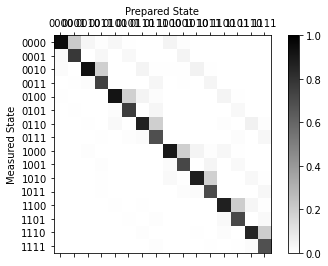

In [7]:
# Generate the calibration circuits
coin = QuantumRegister(1, name = 'coin')
move_id  = QuantumRegister(1, name = 'move_id')
angle_psi = QuantumRegister(1, name = 'angle_psi')
angle_phi = QuantumRegister(1, name = 'angle_phi')
# By order those qubits will be qr[0], qr[1], qr[2] abnd qr[3]


#qubit_list = [angle_phi[0], angle_psi[0], move_id[0], coin[0]]
qr = qiskit.QuantumRegister(4)
qubit_list = [0,1,2,3]
#
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr = qr, circlabel='mcal')

layout = {3: qr[3], 6: qr[2], 4: qr[1], 5: qr[0]}
# layout = {2: angle_psi[0], 3: angle_phi[0], 1: coin[0], 0: move_id[0]} # This is another possible configuration
job = qiskit.execute(meas_calibs, backend=backend, shots=1024, initial_layout=layout)
cal_results = job.result()

# Calculate the calibration matrix with the noise model
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')

# Plot the calibration matrix
meas_fitter.plot_calibration()

Let us first construct the substitute of the oracle

In [8]:
angles = calculate_angles(deltas_dictionary = deltas, beta = .1, scaling_factor = 1)
print(angles)
def hardware_GG_1_coin_flip(circuit,coin,move_id,angle_psi,angle_phi,angles,inv,iteration,beta):
    '''Warning! This only works for GG 1 in hardware mode. Do not use elsewhere!'''
    # First we have to identify the non-zero angles. For the rest we accept with probability 1
    circuit.x(coin)
    '''
    Since the angles from 001 and 101 ~= 2.59; and those from 010 and 000 ~= 0.32 (when beta = .1, 
    but they'll always be similar nevertheless), we will perform those rotations together
    '''
    non_zero_angles = {}
    non_zero_angles['0x0'] = (angles['000']+angles['010'])/2
    non_zero_angles['x01'] = (angles['001']+angles['101'])/2
    
    # Let us first perform the first
    circuit.x(angle_phi)
    circuit.x(move_id)
    circuit.mcrx(theta = -inv*non_zero_angles['0x0'],
                 q_controls = [move_id[0],angle_phi[0]], q_target = coin[0], use_basis_gates=True)
    circuit.x(angle_phi)
    circuit.x(move_id)
    
    # Let us perform the second
    circuit.x(angle_psi)
    circuit.mcrx(theta = -inv*non_zero_angles['x01'],
                 q_controls = [move_id[0],angle_psi[0]], q_target = coin[0], use_basis_gates=True)
    circuit.x(angle_psi)

OrderedDict([('000', 0.328149137182979), ('001', 2.5904722228055745), ('010', 0.3110236124064589), ('011', 0.0), ('100', 0.0), ('101', 2.58969121534896), ('110', 0.0), ('111', 0.0)])


The quantum Walk is composed of several parts, $$W = R V^\dagger B^\dagger F B V,$$
where $V$ prepares possible moves, $B$ is the Boltzmann coin, $F$ the coin flip, and $R$ a reflection of all registers except the state one over state $\ket{0}$. The first thing we do is prepare the oracle


In [9]:
def W_step(qc,coin,move_id,angle_psi,angle_phi,angles,iteration,beta): 
    # Perform the preparation of possible moves----
    qc.h(move_id)

    # Prepare the Boltzmann coin ------------------
    #new_coin_flip(qc,coin,move_id,angle_psi,angle_phi,angles,inverse = 1)
    #map_dependent_coin_flip(qc,ancilla,coin,move_id,angle_psi,angle_phi,angles,1)
    hardware_GG_1_coin_flip(qc,coin,move_id,angle_psi,angle_phi,angles,inv = 1,iteration=iteration,beta = beta)
    
    # Perform move ---------------------------------
    # For the second angle
    qc.ccx(coin,move_id,angle_psi)

    # For the first angle
    qc.x(move_id)
    qc.ccx(coin,move_id,angle_phi)
    qc.x(move_id)

    if iteration == 0:
        # Unprepare the Boltzmann coin--------------------
        #new_coin_flip(qc,coin,move_id,angle_psi,angle_phi,angles,inverse = -1)
        #map_dependent_coin_flip(qc,ancilla,coin,move_id,angle_psi,angle_phi,angles,-1)
        hardware_GG_1_coin_flip(qc,coin,move_id,angle_psi,angle_phi,angles,inv = -1,iteration=0,beta = beta)

        # Perform the preparation of possible moves ----
        qc.h(move_id)

        #Reflection -------------------------------------
        qc.x(move_id)
        qc.x(coin)

        # Perform a multicontrolled Z
        qc.cz(move_id,coin)

        qc.x(move_id)
        qc.x(coin)

Running the model on a backend

In [22]:
def exe(raw_counts = None, mitigated_counts  = None, beta = 1, attemps = 1):
    
    angles = calculate_angles(deltas_dictionary = deltas, beta = beta, scaling_factor = 1)
    
    move_id  = QuantumRegister(1)
    angle_phi = QuantumRegister(1)
    angle_psi = QuantumRegister(1)
    coin = QuantumRegister(1)
    c_reg = ClassicalRegister(4)
    qc = QuantumCircuit(coin,move_id,angle_psi,angle_phi,c_reg)

    #Circuit ----------
    qc.h(angle_phi)
    qc.h(angle_psi)
    for i in [1]:#range(number_W):
        W_step(qc,coin,move_id,angle_psi,angle_phi,angles,i,beta = beta)

    # Measure
    qc.measure(range(4), range(4))

    # Transpiling -------

    #layout = {5: angle_phi[0], 6: angle_psi[0], 4: move_id[0], 5: coin[0]}
    layout = {2: angle_psi[0], 3: angle_phi[0], 1: coin[0], 0: move_id[0]} 
    qc = transpile(qc, backend = backend, seed_transpiler=1, optimization_level=3, initial_layout=layout, basis_gates = ['u1', 'u2', 'u3', 'cx'])
    print('After optimization--------')
    print('gates = ', qc.count_ops())
    print('depth = ', qc.depth())

    job = execute(qc, backend, shots=8192)
    results = job.result()
    
    print('time taken:',results.time_taken )

    # Results without mitigation
    if raw_counts == None:
        raw_counts = results.get_counts()
    else:
        new_raw = results.get_counts()
        for key in raw_counts:
            raw_counts[key] += new_raw[key]


    # Get the filter object
    meas_filter = meas_fitter.filter

    # Results with mitigation
    mitigated_results = meas_filter.apply(results)
    if mitigated_counts == None:
        mitigated_counts = mitigated_results.get_counts()
    else:
        new_miti = mitigated_results.get_counts()
        for key in mitigated_counts:
            mitigated_counts[key] += new_miti[key]
            
    return raw_counts, mitigated_counts

#raw_counts, mitigated_counts = exe(beta = .1)

plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'], color = ['red','orange'])

In [12]:
def calc_probabilities(counts):
    'Calculates the probabilities when measuring the first two qubits'
    new_counts = {}
    for i in ['00','01','10','11']:
        new_counts[i] = 0
    for item in counts:
        new_counts[item[0] + item[1]] += counts[item]
    return new_counts

Let us try some other kind of mitigation of error, using mitiq: https://mitiq.readthedocs.io/en/stable/guide/guide-ibmq-backends.html

In [13]:
def backend_executor(circuit: QuantumCircuit, shots: int = 8192) -> float:
    """Returns the expectation value to be mitigated.

    Args:
        circuit: Circuit to run.
        shots: Number of times to execute the circuit to compute the expectation value.
    """
    # (1) Add measurements to the circuit
    #circuit.measure(circuit.qregs[0], circuit.cregs[0])

    # (2) Run the circuit
    job = qiskit.execute(
        experiments=circuit,
        backend=backend,
        optimization_level=0,  # Important!
        shots=shots
    )

    # (3) Convert from raw measurement counts to the expectation value
    counts = job.result().get_counts()
    print(counts)
    if counts.get("0 0") is None:
        expectation_value = 0.
    else:
        expectation_value = counts.get("0 0") / shots
    return expectation_value

# The circuit ------------------------------------------------------------------------------
def circ_generator(beta = beta):
    move_id  = QuantumRegister(1)
    angle_phi = QuantumRegister(1)
    angle_psi = QuantumRegister(1)
    coin = QuantumRegister(1)
    c_reg = ClassicalRegister(4)
    qc = QuantumCircuit(coin,move_id,angle_psi,angle_phi,c_reg)

    number_W = 2 # Parameter

    #Circuit ----------
    qc.h(angle_phi)
    qc.h(angle_psi)
    for i in [1]:#range(number_W):
        W_step(qc,coin,move_id,angle_psi,angle_phi,angles,i,beta = beta)

    # Measure
    qc.measure([2,3], [2,3])

    # Transpiling -------
    layout = {3: angle_phi[0], 6: angle_psi[0], 4: move_id[0], 5: coin[0]}
    qc = transpile(qc, backend = backend, seed_transpiler=1, optimization_level=3, initial_layout=layout, basis_gates = ['u1', 'u2', 'u3', 'cx'])
    print('After optimization--------')
    print('gates = ', qc.count_ops())
    print('depth = ', qc.depth())
    return qc
    
# Executing the mitigation ----------------------------------------------------------
'''miti= {}
miti['11'] = 0
miti['00'] = mitiq.execute_with_zne(circ_generator(beta = beta), backend_executor)
miti['01'] = 0
miti['10'] = 0
print(miti['00'])'''

"miti= {}\nmiti['11'] = 0\nmiti['00'] = mitiq.execute_with_zne(circ_generator(beta = beta), backend_executor)\nmiti['01'] = 0\nmiti['10'] = 0\nprint(miti['00'])"

from mitiq.mitiq_qiskit.conversions import to_qiskit
#from mitiq.mitiq_qiskit.qiskit_utils import random_identity_circuit
from mitiq.zne.scaling import fold_gates_at_random
from mitiq.zne.scaling import fold_local

scale_factors = [1., 1.5, 2., 2.5, 3.]
folded_circuits = [
        mitiq.zne.scaling.fold_local(
        qc, scale, method=mitiq.zne.scaling.fold_gates_at_random
    ) for scale in scale_factors
]
for folded_circuit in folded_circuits:
    folded_circuit.measure([qreg for qreg in folded_circuit.qregs if (qreg.name == 'angle_psi' or qreg.name == 'angle_phi')], 
                           folded_circuit.cregs[3:])
job = qiskit.execute(
   experiments=folded_circuits,
   backend=backend,
   optimization_level=0,  # Important!
   shots=shots
)
all_counts = [job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = [counts.get() / shots for counts in all_counts]
print(expectation_values)

fac = mitiq.zne.inference.LinearFactory(scale_factors)
fac.instack, fac.outstack = scale_factors, expectation_values
zero_noise_value = fac.reduce()
print("Extrapolated zero-noise value:", round(zero_noise_value, 3))


The same circuit without error can be seen in

In [14]:
def exe_noiseless(beta = beta):
    
    angles = calculate_angles(deltas_dictionary = deltas, beta = beta, scaling_factor = 1)
    
    move_id  = QuantumRegister(1, name = 'move_id')
    angle_phi = QuantumRegister(1, name = 'angle_phi')
    angle_psi = QuantumRegister(1, name = 'angle_psi')
    coin = QuantumRegister(1, name = 'coin')
    c_reg = ClassicalRegister(4)
    aerqc = QuantumCircuit(coin,move_id,angle_psi,angle_phi,c_reg)

    #Circuit ----------
    aerqc.h(angle_phi)
    aerqc.h(angle_psi)
    for i in [1]:#range(number_W):
        W_step(aerqc,coin,move_id,angle_psi,angle_phi,angles,i,beta)

    # Measure
    aerbackend = Aer.get_backend('statevector_simulator')
    backend_options = {"method" : "statevector"}
    experiment = execute(aerqc, aerbackend, backend_options=backend_options)
    state_vector = Statevector(experiment.result().get_statevector(aerqc))

    probabilities = state_vector.probabilities([3,2])
    noiseless_counts = {}
    noiseless_counts['00'] = float(probabilities[0])
    noiseless_counts['01'] = float(probabilities[1])
    noiseless_counts['10'] = float(probabilities[2])
    noiseless_counts['11'] = float(probabilities[3])

    return noiseless_counts
    #plot_histogram(noiseless_counts)
#noiseless_counts = exe_noiseless(beta = beta)

In [15]:
#plot_histogram([calc_probabilities(raw_counts), calc_probabilities(mitigated_counts),miti,noiseless_counts], legend=['raw', 'mitigated','mitiq','noiseless'], color = ['red','orange','yellow','green'])
#plot_histogram([calc_probabilities(raw_counts), calc_probabilities(mitigated_counts),noiseless_counts], legend=['raw', 'mitigated','noiseless'], color = ['red','orange','green'])

for beta in [0,0.1,1,10,100000]:
    raw_counts, mitigated_counts = exe(beta = beta)
    noiseless_counts = exe_noiseless(beta = beta)
    plot = plot_histogram([calc_probabilities(raw_counts), 
                    calc_probabilities(mitigated_counts),
                    noiseless_counts], 
                   legend=['raw', 'mitigated','noiseless'], color = ['red','orange','green'])
    
    plot.savefig('histogram'+str(beta)+'.png')
    plot.show()

After optimization--------
gates =  OrderedDict([('u2', 29), ('cx', 25), ('u3', 9), ('u1', 7), ('measure', 4), ('barrier', 1)])
depth =  48


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.


After optimization--------
gates =  OrderedDict([('cx', 47), ('u2', 38), ('u3', 16), ('u1', 10), ('measure', 2), ('barrier', 1)])
depth =  80
{'0 0': 2150, '0 1': 1880, '1 0': 2308, '1 1': 1854}
{'0 0': 1752, '0 1': 2171, '1 0': 1918, '1 1': 2351}
{'0 0': 1557, '0 1': 2510, '1 0': 1604, '1 1': 2521}
0.33581542968749983


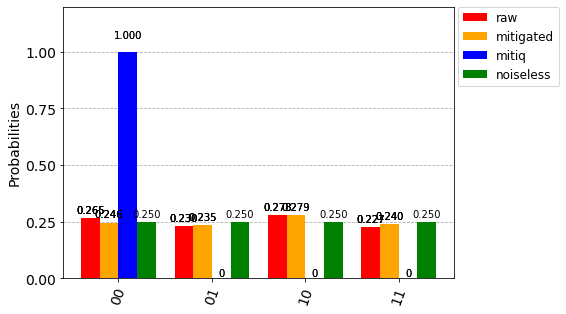

In [16]:
beta = 0
raw_counts, mitigated_counts = exe(beta = beta)
noiseless_counts = exe_noiseless(beta = beta)
# Executing the mitigation ----------------------------------------------------------
miti = {}
for i in range(4):
    miti[np.binary_repr(i,width = 2)] = 0
    
miti['00'] = mitiq.execute_with_zne(circ_generator(beta = beta), backend_executor)

print(miti['00'])
plot = plot_histogram([calc_probabilities(raw_counts), 
                calc_probabilities(mitigated_counts),
                miti,noiseless_counts], 
               legend=['raw', 'mitigated','mitiq','noiseless'], color = ['red','orange','blue','green'])

plot.savefig('histogram_hardware_GG1_1step_'+str(beta)+'.png')
plot

In [23]:
beta = 0.1
raw_counts, mitigated_counts = exe(beta = beta)
noiseless_counts = exe_noiseless(beta = beta)
# Executing the mitigation ----------------------------------------------------------
miti = {}
for i in range(4):
    miti[np.binary_repr(i,width = 2)] = 0
    
miti['00'] = mitiq.execute_with_zne(circ_generator(beta = beta), backend_executor)

print(miti['00'])
plot = plot_histogram([calc_probabilities(raw_counts), 
                calc_probabilities(mitigated_counts),
                miti,noiseless_counts], 
               legend=['raw', 'mitigated','mitiq','noiseless'], color = ['red','orange','blue','green'])

plot.savefig('histogram_hardware_GG1_1step_'+str(beta)+'.png')
plot

After optimization--------
gates =  OrderedDict([('cx', 41), ('u2', 37), ('u3', 17), ('u1', 7), ('measure', 4), ('barrier', 1)])
depth =  72
time taken: 32.484755992889404


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.


After optimization--------
gates =  OrderedDict([('cx', 47), ('u2', 38), ('u3', 16), ('u1', 10), ('measure', 2), ('barrier', 1)])
depth =  80
{'0 0': 2496, '0 1': 2070, '1 0': 1996, '1 1': 1630}


KeyboardInterrupt: 

After optimization--------
gates =  OrderedDict([('cx', 41), ('u2', 37), ('u3', 17), ('u1', 7), ('measure', 4), ('barrier', 1)])
depth =  72


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.


After optimization--------
gates =  OrderedDict([('cx', 47), ('u2', 38), ('u3', 16), ('u1', 10), ('measure', 2), ('barrier', 1)])
depth =  80
{'0 0': 2248, '0 1': 1813, '1 0': 2379, '1 1': 1752}
{'0 0': 1937, '0 1': 2124, '1 0': 1923, '1 1': 2208}
{'0 0': 1790, '0 1': 2307, '1 0': 1762, '1 1': 2333}
0.3323974609375003


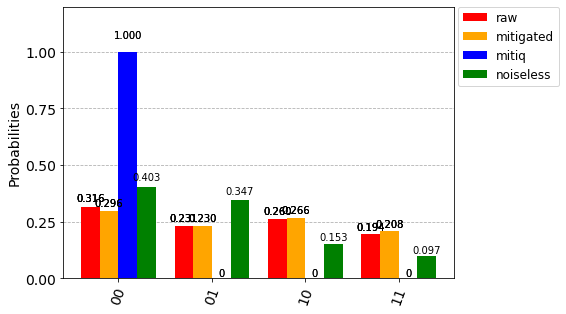

In [18]:
beta = 1
raw_counts, mitigated_counts = exe(beta = beta)
noiseless_counts = exe_noiseless(beta = beta)
# Executing the mitigation ----------------------------------------------------------
miti = {}
for i in range(4):
    miti[np.binary_repr(i,width = 2)] = 0
    
miti['00'] = mitiq.execute_with_zne(circ_generator(beta = beta), backend_executor)

print(miti['00'])
plot = plot_histogram([calc_probabilities(raw_counts), 
                calc_probabilities(mitigated_counts),
                miti,noiseless_counts], 
               legend=['raw', 'mitigated','mitiq','noiseless'], color = ['red','orange','blue','green'])

plot.savefig('histogram_hardware_GG1_1step_'+str(beta)+'.png')
plot

After optimization--------
gates =  OrderedDict([('cx', 41), ('u2', 37), ('u3', 17), ('u1', 7), ('measure', 4), ('barrier', 1)])
depth =  72


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.


After optimization--------
gates =  OrderedDict([('cx', 47), ('u2', 38), ('u3', 16), ('u1', 10), ('measure', 2), ('barrier', 1)])
depth =  80
{'0 0': 2037, '0 1': 2476, '1 0': 1715, '1 1': 1964}
{'0 0': 1633, '0 1': 2160, '1 0': 1915, '1 1': 2484}
{'0 0': 1465, '0 1': 2391, '1 0': 1676, '1 1': 2660}
0.32678222656250006


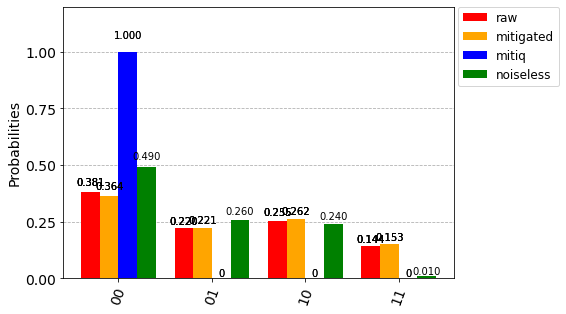

In [19]:
beta = 10
raw_counts, mitigated_counts = exe(beta = beta)
noiseless_counts = exe_noiseless(beta = beta)
# Executing the mitigation ----------------------------------------------------------
miti = {}
for i in range(4):
    miti[np.binary_repr(i,width = 2)] = 0
    
miti['00'] = mitiq.execute_with_zne(circ_generator(beta = beta), backend_executor)

print(miti['00'])
plot = plot_histogram([calc_probabilities(raw_counts), 
                calc_probabilities(mitigated_counts),
                miti,noiseless_counts], 
               legend=['raw', 'mitigated','mitiq','noiseless'], color = ['red','orange','blue','green'])

plot.savefig('histogram_hardware_GG1_1step_'+str(beta)+'.png')
plot

After optimization--------
gates =  OrderedDict([('cx', 41), ('u2', 37), ('u3', 17), ('u1', 7), ('measure', 4), ('barrier', 1)])
depth =  72


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.


After optimization--------
gates =  OrderedDict([('cx', 47), ('u2', 38), ('u3', 16), ('u1', 10), ('measure', 2), ('barrier', 1)])
depth =  80
{'0 0': 1996, '0 1': 2077, '1 0': 2158, '1 1': 1961}
{'0 0': 1968, '0 1': 2269, '1 0': 1870, '1 1': 2085}
{'0 0': 1820, '0 1': 2186, '1 0': 1851, '1 1': 2335}
0.23242187499999967


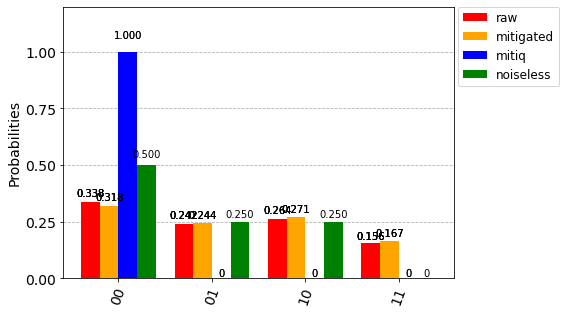

In [20]:
beta = 10000
raw_counts, mitigated_counts = exe(beta = beta)
noiseless_counts = exe_noiseless(beta = beta)
# Executing the mitigation ----------------------------------------------------------
miti = {}
for i in range(4):
    miti[np.binary_repr(i,width = 2)] = 0
    
miti['00'] = mitiq.execute_with_zne(circ_generator(beta = beta), backend_executor)

print(miti['00'])
plot = plot_histogram([calc_probabilities(raw_counts), 
                calc_probabilities(mitigated_counts),
                miti,noiseless_counts], 
               legend=['raw', 'mitigated','mitiq','noiseless'], color = ['red','orange','blue','green'])

plot.savefig('histogram_hardware_GG1_1step_'+str(beta)+'.png')
plot

However, the mitiq package is not really able to spot the correct answer. It is returning 1 for the measured

In [ ]:
beta = 0
raw_counts, mitigated_counts = exe(beta = beta)
noiseless_counts = exe_noiseless(beta = beta)
# Executing the mitigation ----------------------------------------------------------
miti = {}
for i in range(4):
    miti[np.binary_repr(i,width = 2)] = 0
    
miti['11'] = mitiq.execute_with_zne(circ_generator(beta = beta), backend_executor)

print(miti['11'])
plot = plot_histogram([calc_probabilities(raw_counts), 
                calc_probabilities(mitigated_counts),
                miti,noiseless_counts], 
               legend=['raw', 'mitigated','mitiq','noiseless'], color = ['red','orange','blue','green'])

#plot.savefig('histogram_hardware_GG1_'+str(beta)+'.png')
plot

In [24]:
(1-1e-2)**100

0.3660323412732292